In [37]:
from pathlib import Path

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interpolate

import project_path
import nn.utils as utils
import nn.model.net as net
import nn.model.data as data
import nn.model.loss as loss

## Constants

In [38]:
NUM_CLASSES = 5
CLASSES = ['Gluon', 'Lght quarks', 'W boson', 'Z boson', 'Top quark']
MODEL_DIR = Path("../../../experiments/pre_train/constituent_graph/best.script.pth")

In [39]:
torch.manual_seed(230)

## Data

In [40]:
# (1) creating dataset
datasets = data.get_dataset(splits=['train-val', 'test'])
dataset = datasets['train-val']
test_set = datasets['test']

# (2) train-validation split
dataset_size = len(dataset)
train_set, val_set, _ = torch.utils.data.random_split(dataset, [dataset_size - 1000, 1000, 0])

# (3) train-validation dataloaders
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=data.get_collate_fn())
val_loader = data.DataLoader(val_set, batch_size=32, collate_fn=data.get_collate_fn())
test_loader = data.DataLoader(test_set, batch_size=32, collate_fn=data.get_collate_fn())

## Model

In [31]:
model = torch.jit.load(MODEL_DIR)
print(f'Number of parameters: {utils.count_parameters(model)}')
model.eval()

Number of parameters: 156709


RecursiveScriptModule(
  original_name=ConstituentNetGraph
  (inp_layer): RecursiveScriptModule(original_name=Linear)
  (graph_assign): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Softmax)
  )
  (convs): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=BatchNorm1d)
    (1): RecursiveScriptModule(original_name=Conv1d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=BatchNorm1d)
    (4): RecursiveScriptModule(original_name=Conv1d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=BatchNorm1d)
    (7): RecursiveScriptModule(original_name=Conv1d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(original_name=BatchNorm1d)
    (10): RecursiveScriptModule(original_name=Conv1d)
    (11): RecursiveScriptModule(original

## Evaluation

In [7]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:13<00:00,  2.29s/batch]


### Confusion Matrix

Accuracy:  0.809


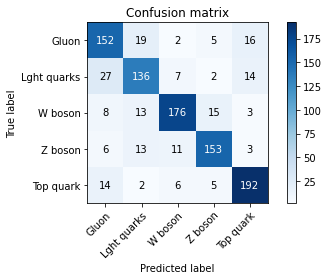

In [8]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [9]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

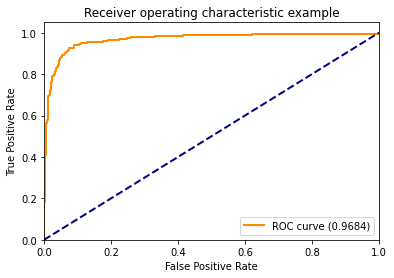

In [10]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.8402061855670103
 Lght quarks: 0.8225806451612904
 W boson:     0.8837209302325582
 Z boson:     0.9139784946236559
 Top quark:   0.9406392694063926

TPR for FPR = 1%
 Gluon:       0.5103092783505154
 Lght quarks: 0.3118279569892473
 W boson:     0.5116279069767442
 Z boson:     0.5967741935483871
 Top quark:   0.5799086757990868


## Test

In [12]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(test_loader), unit="batch") as t:
    for i, batch in enumerate(test_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:03<00:00,  2.54batch/s]


### Confusion Matrix

Accuracy:  0.7976


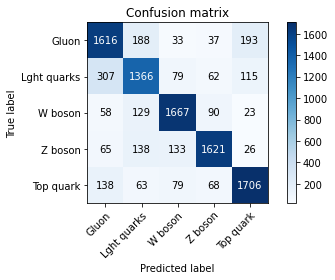

In [13]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [14]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

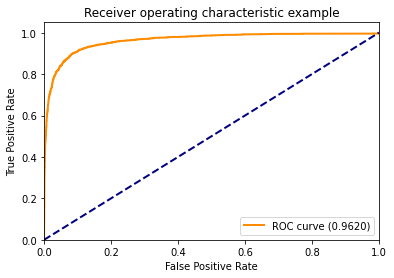

In [15]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.8505079825834543
 Lght quarks: 0.7967858994297563
 W boson:     0.922216573462125
 Z boson:     0.8895612708018155
 Top quark:   0.9099318403115871

TPR for FPR = 1%
 Gluon:       0.4107402031930334
 Lght quarks: 0.2623120787973043
 W boson:     0.6192170818505338
 Z boson:     0.7332324760463943
 Top quark:   0.618792599805258


## Prunning
Simulate data-loss or partially decision

### Simulate one large-branch is entirely dropped

In [41]:
# Ref of model state dict
state_dict = model.state_dict()

# Mask 1/4 of nodes
state_dict['graph_assign.0.weight'][48:64].zero_()
print(model.state_dict()['graph_assign.0.weight'])

tensor([[-8.4770e-02,  7.3520e-02,  5.8557e-02,  ...,  1.2933e+00,
         -2.6405e-01, -2.4452e-01],
        [-5.6065e-03,  6.9369e-02,  4.0781e-01,  ...,  1.3475e+00,
          5.6373e-01,  1.2766e-01],
        [-6.6141e-02,  3.0235e-02, -2.9447e-03,  ..., -1.3551e+00,
         -3.0306e-02,  4.0738e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [42]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:16<00:00,  2.38s/batch]


Accuracy:  0.78


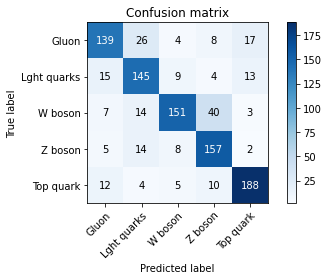

In [43]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### Simulate a quarter of noded randomly dropped

In [92]:
# Reload model
model = torch.jit.load(MODEL_DIR)
model.eval()

# Ref of model state dict
state_dict = model.state_dict()

# Nodes to mask
masks = torch.randperm(64)[:16].tolist()

# Mask 1/4 of nodes
for row in masks:
    state_dict['graph_assign.0.weight'][row].zero_()
print(model.state_dict()['graph_assign.0.weight'])

tensor([[-0.0848,  0.0735,  0.0586,  ...,  1.2933, -0.2641, -0.2445],
        [-0.0056,  0.0694,  0.4078,  ...,  1.3475,  0.5637,  0.1277],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.5294, -0.3495,  0.3153,  ..., -0.5053,  0.5366,  1.4339],
        [-0.0680,  0.0400, -0.0254,  ...,  2.1323, -0.0800, -0.4929]])


In [93]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:11<00:00,  2.84batch/s]


Accuracy:  0.654


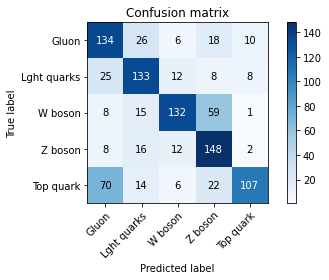

In [94]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

In [87]:
masks

[42, 60, 16, 61, 6, 14, 41, 40, 54, 1, 23, 59, 33, 9, 21, 36]